In [1]:
import pip

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('student-mat.csv', sep=';')

# See the first few rows
print("Data Head:")
print(df.head())

# Get a summary of the data types and non-null values
print("\nData Info:")
df.info()

# Get descriptive statistics for numerical columns
print("\nData Description:")
print(df.describe())

Data Head:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 

In [4]:
# Create a new binary column 'final_pass'
# In Portugal, a grade of 10 or higher (out of 20) is typically a passing grade.
df['final_pass'] = (df['G3'] >= 10).astype(int) # 1 for Pass, 0 for Fail

print("\nValue counts for final_pass:")
print(df['final_pass'].value_counts())


Value counts for final_pass:
final_pass
1    265
0    130
Name: count, dtype: int64


In [5]:
# Set plot style
sns.set_style('whitegrid')

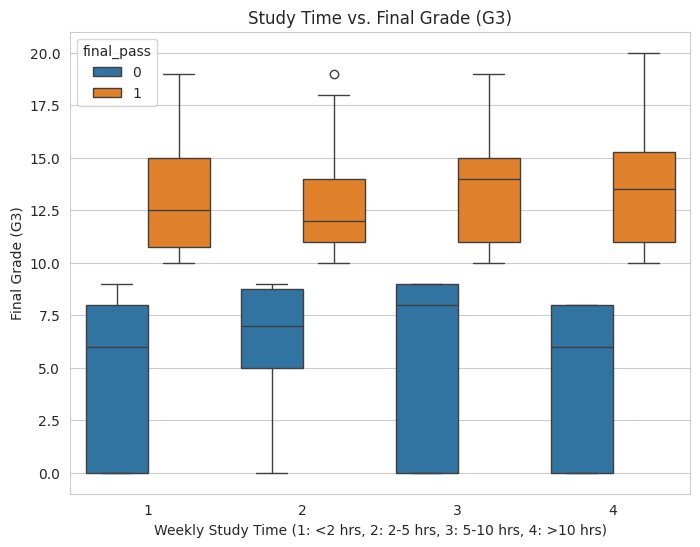

In [6]:
# 1. How does study time affect the final outcome?
plt.figure(figsize=(8, 6))
sns.boxplot(x='studytime', y='G3', data=df, hue='final_pass')
plt.title('Study Time vs. Final Grade (G3)')
plt.xlabel('Weekly Study Time (1: <2 hrs, 2: 2-5 hrs, 3: 5-10 hrs, 4: >10 hrs)')
plt.ylabel('Final Grade (G3)')
plt.show()

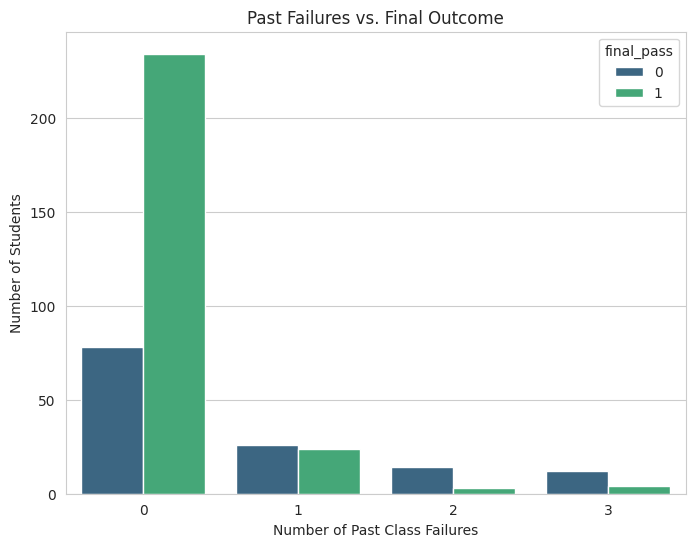

In [7]:
# 2. Are past failures a strong indicator of the final outcome?
plt.figure(figsize=(8, 6))
sns.countplot(x='failures', data=df, hue='final_pass', palette='viridis')
plt.title('Past Failures vs. Final Outcome')
plt.xlabel('Number of Past Class Failures')
plt.ylabel('Number of Students')
plt.show()

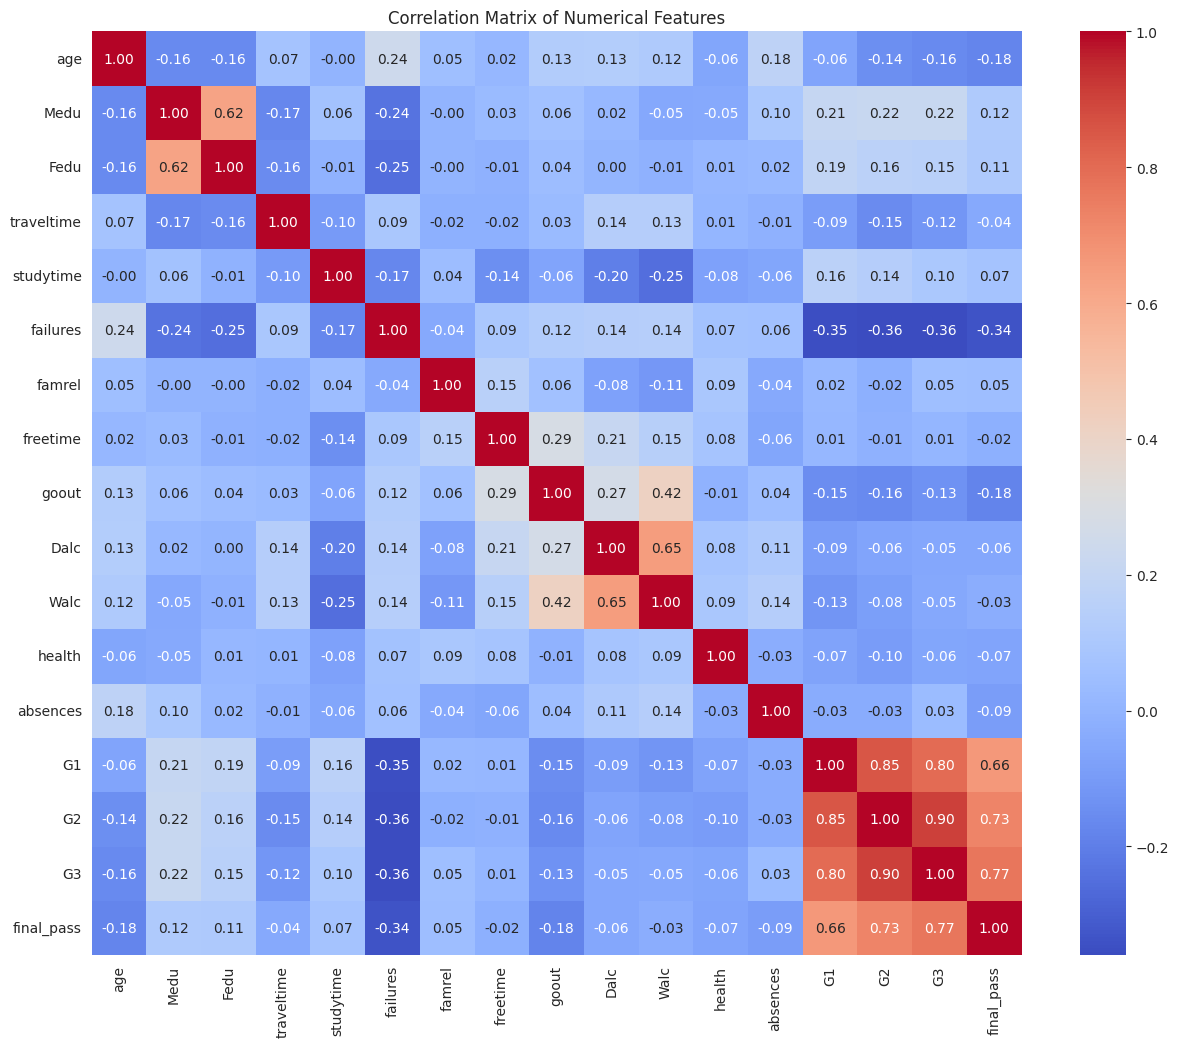

In [8]:
# 3. Correlation Heatmap for numerical features
plt.figure(figsize=(15, 12))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [9]:
# Select features
features = df.drop(['G1', 'G2', 'G3', 'final_pass'], axis=1)
target = df['final_pass']

In [10]:
# One-hot encode categorical features
features_processed = pd.get_dummies(features, drop_first=True)

print("\nShape of processed features:", features_processed.shape)
print("Columns after encoding:", features_processed.columns)


Shape of processed features: (395, 39)
Columns after encoding: Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS',
       'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_processed,
    target,
    test_size=0.2, # 20% for testing
    random_state=42 # for reproducibility
)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

# View the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# View the classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.66

Confusion Matrix:
[[ 5 22]
 [ 5 47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.27        27
           1       0.68      0.90      0.78        52

    accuracy                           0.66        79
   macro avg       0.59      0.54      0.52        79
weighted avg       0.62      0.66      0.60        79



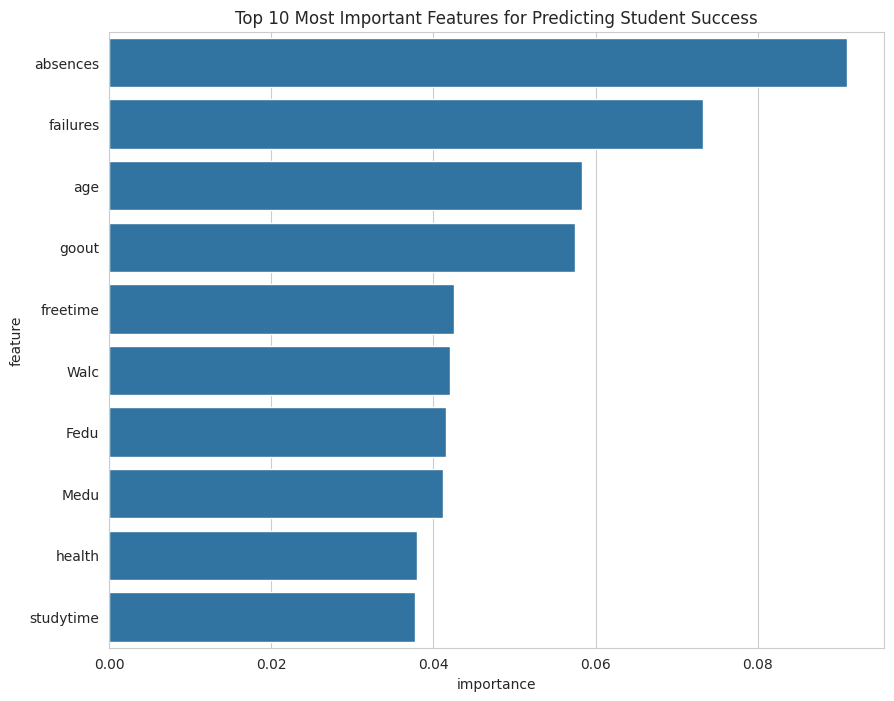

In [14]:
# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = features_processed.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10) # Top 10

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 10 Most Important Features for Predicting Student Success')
plt.show()

In [15]:
def predict_student_outcome(student_data, trained_model, feature_columns):
    """
    Predicts the academic outcome for a new student.

    Args:
        student_data (dict): A dictionary containing the student's data.
        trained_model: The trained scikit-learn model.
        feature_columns (list): The list of columns used for training (after one-hot encoding).

    Returns:
        str: The prediction ('Pass' or 'Fail').
    """
    # Create a DataFrame from the new data
    new_student_df = pd.DataFrame([student_data])

    # One-hot encode the new data
    new_student_processed = pd.get_dummies(new_student_df)

    # Align columns with the training data
    # This adds missing columns with a value of 0 and ensures order is the same
    new_student_aligned = new_student_processed.reindex(columns=feature_columns, fill_value=0)

    # Make a prediction
    prediction = trained_model.predict(new_student_aligned)

    return 'Pass' if prediction[0] == 1 else 'Fail'

# --- Example Usage ---
# Create a hypothetical new student
new_student = {
    'school': 'GP', 'sex': 'F', 'age': 17, 'address': 'U',
    'famsize': 'GT3', 'Pstatus': 'T', 'Medu': 4, 'Fedu': 4,
    'Mjob': 'teacher', 'Fjob': 'health', 'reason': 'course',
    'guardian': 'mother', 'traveltime': 1, 'studytime': 3,
    'failures': 0, 'schoolsup': 'no', 'famsup': 'yes',
    'paid': 'yes', 'activities': 'no', 'nursery': 'yes',
    'higher': 'yes', 'internet': 'yes', 'romantic': 'no',
    'famrel': 4, 'freetime': 3, 'goout': 2, 'Dalc': 1,
    'Walc': 1, 'health': 3, 'absences': 4
}

# Use the function to make a prediction
predicted_status = predict_student_outcome(new_student, model, features_processed.columns)
print(f"\nPrediction for the new student: {predicted_status}")


Prediction for the new student: Pass
